In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib.ticker import StrMethodFormatter, FuncFormatter
from datetime import timedelta
import re 

# DATA PREPARATION TO ANALYZE

def parse_row(row):
    state, user_action, msg  = re.findall(r'\[(.*?)\]', row.message)
    return pd.Series ({
        'actionID': row.actionId,
        'action': user_action,
        'state': state,
        'time': row.createdDateTime,
        'msg': msg
    })

def collapse(group: pd.DataFrame):
    actionId, user_action, is_start, time_start, msg_start = group.iloc[0]
    _, _, is_end, time_end, msg_end = group.iloc[1] if group.index.size == 2 else (None, None, None, None, None)
    if is_start != 'START': #swap_values
        msg_start, msg_end = msg_end, msg_start
        time_start, time_end = time_end, time_start
    def parse_msg(msg, user_action=user_action):
        return re.findall(r'\d+', msg) if msg and user_action != 'SEARCH' else [0,0,0]
    return pd.Series({
        'started_at': time_start,
        'week': time_start.week if time_start else None,
        'duration': time_end - time_start if time_end and time_start else None,
        'num_records': int(parse_msg(msg_start)[0]),
        'num_success': int(parse_msg(msg_end)[0]),
        'num_failed': int(parse_msg(msg_end)[1]),
        'num_warning': int(parse_msg(msg_end)[2])
    })

user_actions=pd.read_csv('user_actions.csv', 
                         usecols = lambda col : col != "currentUser", 
                         dtype={'message': str}, 
                         parse_dates=['createdDateTime'])\
                .apply(parse_row, axis=1)\
                .groupby(['actionID', 'action'])\
                .apply(collapse)\
                .reset_index()

user_actions

In [2]:
original_data = pd.read_csv('user_actions.csv', 
                            usecols = lambda col : col != "currentUser",
                            parse_dates=['createdDateTime']).set_index('actionId')
original_data['state'] = original_data['message'].str.extract(r'\[(.*?)\]', expand=False)
original_data['action'] = original_data['message'].str.extract(r'\[.*?\[(.*?)\]', expand=False)

In [3]:
start_df = original_data[original_data['state'] == 'START']
end_df = original_data[original_data['state'] == 'END']

In [4]:
user_actions = pd.DataFrame(index=original_data.index.drop_duplicates())

In [5]:
user_actions['start_action'] = start_df['action']
user_actions['end_action'] = end_df['action']
user_actions['started_at'] = start_df['createdDateTime']
user_actions['ended_at'] = end_df['createdDateTime']
user_actions['duration'] = user_actions['ended_at'] - user_actions['started_at']
user_actions['week'] = start_df['createdDateTime'].dt.week
user_actions['num_records'] = start_df['message'].str.extract(r'num_records=(\d+)', expand=False).astype(float)
user_actions['num_success'] = end_df['message'].str.extract(r'num_success=(\d+)', expand=False).astype(float)
user_actions['num_failed'] = end_df['message'].str.extract(r'num_failed=(\d+)', expand=False).astype(float)
user_actions['num_warning'] = end_df['message'].str.extract(r'num_warning=(\d+)', expand=False).astype(float)
user_actions.loc[user_actions['start_action'] == 'SEARCH',\
                 ['num_records', 'num_success', 'num_failed', 'num_warning']] = 0
user_actions.loc[user_actions['start_action'] != user_actions['end_action'],\
                 ['num_records', 'num_success', 'num_failed', 'num_warning']] = None
user_actions.rename(columns={"start_action": "action"}, inplace=True)
user_actions.drop(columns=['end_action', 'ended_at'], inplace=True)
user_actions

,action,started_at,duration,week,num_records,num_success,num_failed,num_warning
actionId,,,,,,,,
875ee856-7376-4d2b-bdb3-159696551ea9,IMPORT,2019-10-03 14:11:00,00:01:23,40.0,139.0,2.0,1.0,136.0
7c592432-a361-41e9-9e1d-3b7097e74447,SEARCH,2019-10-23 10:10:00,00:10:06,43.0,0.0,0.0,0.0,0.0
9f2287f6-425a-4d5a-9381-bec13285e2fc,IMPORT,2019-06-03 14:36:00,00:03:38,23.0,497.0,296.0,196.0,5.0
b830e027-5f2b-41fc-bd19-9580e0f25cea,APPROVE,2019-04-03 12:56:00,00:01:10,14.0,512.0,2.0,495.0,15.0
f4d9f09f-f83c-41a4-9abd-fd5c66bf1bfb,IMPORT,2019-02-10 15:07:00,00:00:40,6.0,64.0,41.0,8.0,15.0
...,...,...,...,...,...,...,...,...
78a9ddf6-1038-4846-9ce4-e4005546375c,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
2f79c34c-b588-4276-b1fd-d55b80fa0759,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
93b8c1b9-df83-4c4c-84fc-697648c778c8,IMPORT,2019-04-22 12:59:00,NaT,17.0,NaN,NaN,NaN,NaN


## Retrieving Data That Cannot Be Processed

In [6]:
user_actions[user_actions.isna().any(axis = 1)] 

,action,started_at,duration,week,num_records,num_success,num_failed,num_warning
actionId,,,,,,,,
584ec2be-2d3e-4896-8e69-4412cc097e04,SEARCH,2019-01-07 10:42:00,NaT,2.0,NaN,NaN,NaN,NaN
9b42e975-3019-4e42-9bc1-5f8e63e1eb72,APPROVE,2019-05-31 15:11:00,NaT,22.0,NaN,NaN,NaN,NaN
60aa50a6-3eea-449c-9cd9-f25c23ae23e9,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
258a788f-c45c-456d-8ec3-6bf3dcdf319a,IMPORT,2019-04-17 15:30:00,NaT,16.0,NaN,NaN,NaN,NaN
af7c80bb-a37d-43f6-9fe8-fe1d2ba4a738,APPROVE,2019-05-11 11:11:00,NaT,19.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
78a9ddf6-1038-4846-9ce4-e4005546375c,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
2f79c34c-b588-4276-b1fd-d55b80fa0759,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
93b8c1b9-df83-4c4c-84fc-697648c778c8,IMPORT,2019-04-22 12:59:00,NaT,17.0,NaN,NaN,NaN,NaN


In [7]:
user_actions.isna().sum(axis = 0)

action         461
started_at     461
duration       935
week           461
num_records    935
num_success    935
num_failed     935
num_warning    935
dtype: int64

In [8]:
user_actions.dropna(inplace=True)
user_actions.reset_index(inplace=True)

# TASK

## Percentage of operations (pie chart)

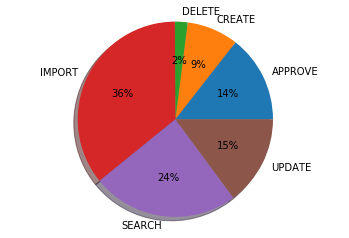

In [9]:
actions = user_actions.groupby('action').size()

fig, ax = plt.subplots()
ax.pie(actions, labels=actions.index, autopct='%.0f%%', shadow=True, radius=0.5)
ax.axis('equal')
plt.show()

## The total number of operations by weeks

Text(0, 0.5, 'num_actions')

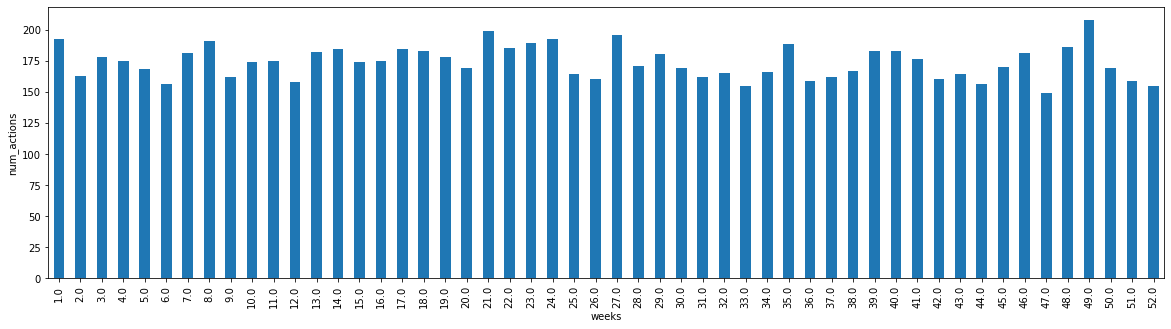

In [10]:
ax = user_actions.groupby('week').size()\
                .plot(x='createdDateTime_start', kind='bar', legend=False, figsize=(20,5))
ax.set_xlabel("weeks")
ax.set_ylabel("num_actions")

## Top 10 most lengthy searching operations indicating time spent

In [12]:
user_actions[user_actions['action'] == 'SEARCH'][['actionId', 'action', 'duration']]\
            .sort_values(['duration'], ascending=False)[:10]

,actionId,action,duration
3156,9e63c4d8-2764-465e-ab8a-83446f94240e,SEARCH,00:16:23
3122,5497fc04-9b2e-4a92-a947-0b45511b3f73,SEARCH,00:16:20
6438,8e39d016-95b4-4008-82e3-bd42a9ae2c36,SEARCH,00:16:19
6966,175c84ff-51ba-487b-90f9-89f9cc429b51,SEARCH,00:16:16
1211,1b8aa553-979c-47ec-80aa-c4622140b3ef,SEARCH,00:15:55
6703,59b622bb-7e9b-4219-9bc3-1f262af0d1c6,SEARCH,00:15:54
3201,79c1f320-41e7-4b5a-bf8a-bf266b5e0f53,SEARCH,00:15:42
1152,6b89eb63-b998-4cc7-8cf4-b7cfea678171,SEARCH,00:15:36
7801,21248776-e024-431d-ae54-8aab2fc85a53,SEARCH,00:15:34
6959,21d24895-dcf7-4d77-a95a-8fa4bbe6b21a,SEARCH,00:15:33


In [13]:
not_srch_act = user_actions[user_actions['action'] != 'SEARCH']

## A histogram of input data for each operation

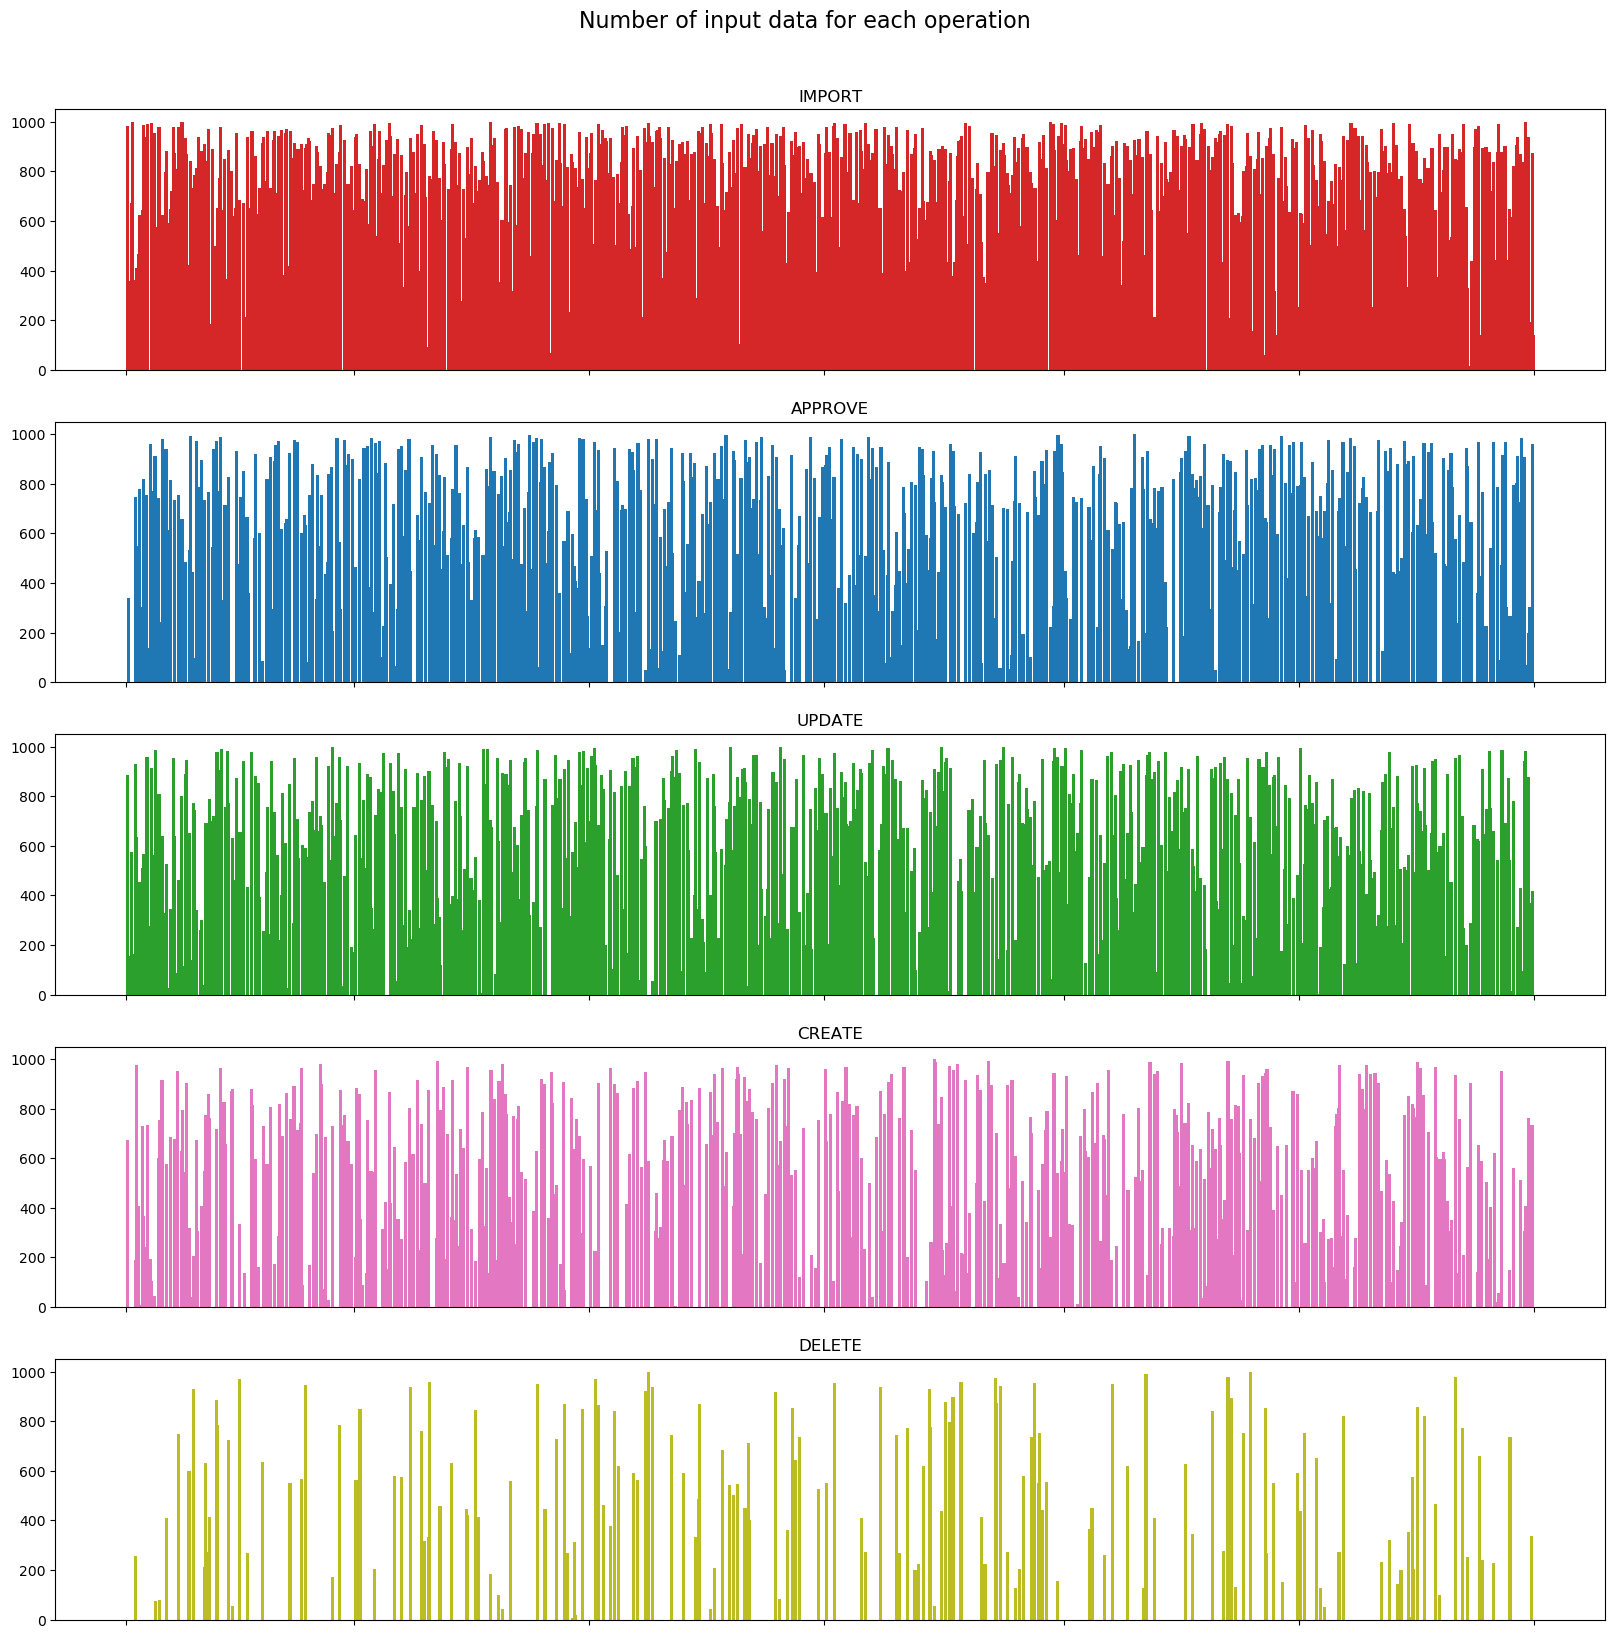

In [13]:
_, axes = plt.subplots(5, 1, figsize=(20,20), dpi=100, sharex=True, sharey=True)
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:pink', 'tab:olive']

for i, (ax, action) in enumerate(zip(axes.flatten(), not_srch_act.action.unique())):
    y = not_srch_act.loc[not_srch_act.action==action, 'num_records']
    x = not_srch_act.loc[not_srch_act.action==action, 'started_at']
    ax.bar(x=x, height=y, alpha=1, color=colors[i])
    ax.set_xticklabels([])
    ax.set_title(action) 
    
plt.suptitle('Number of input data for each operation', y=0.93, size=16)
plt.show()

## Graph of the number of successful, conditionally successful (warning) and unsuccessful results

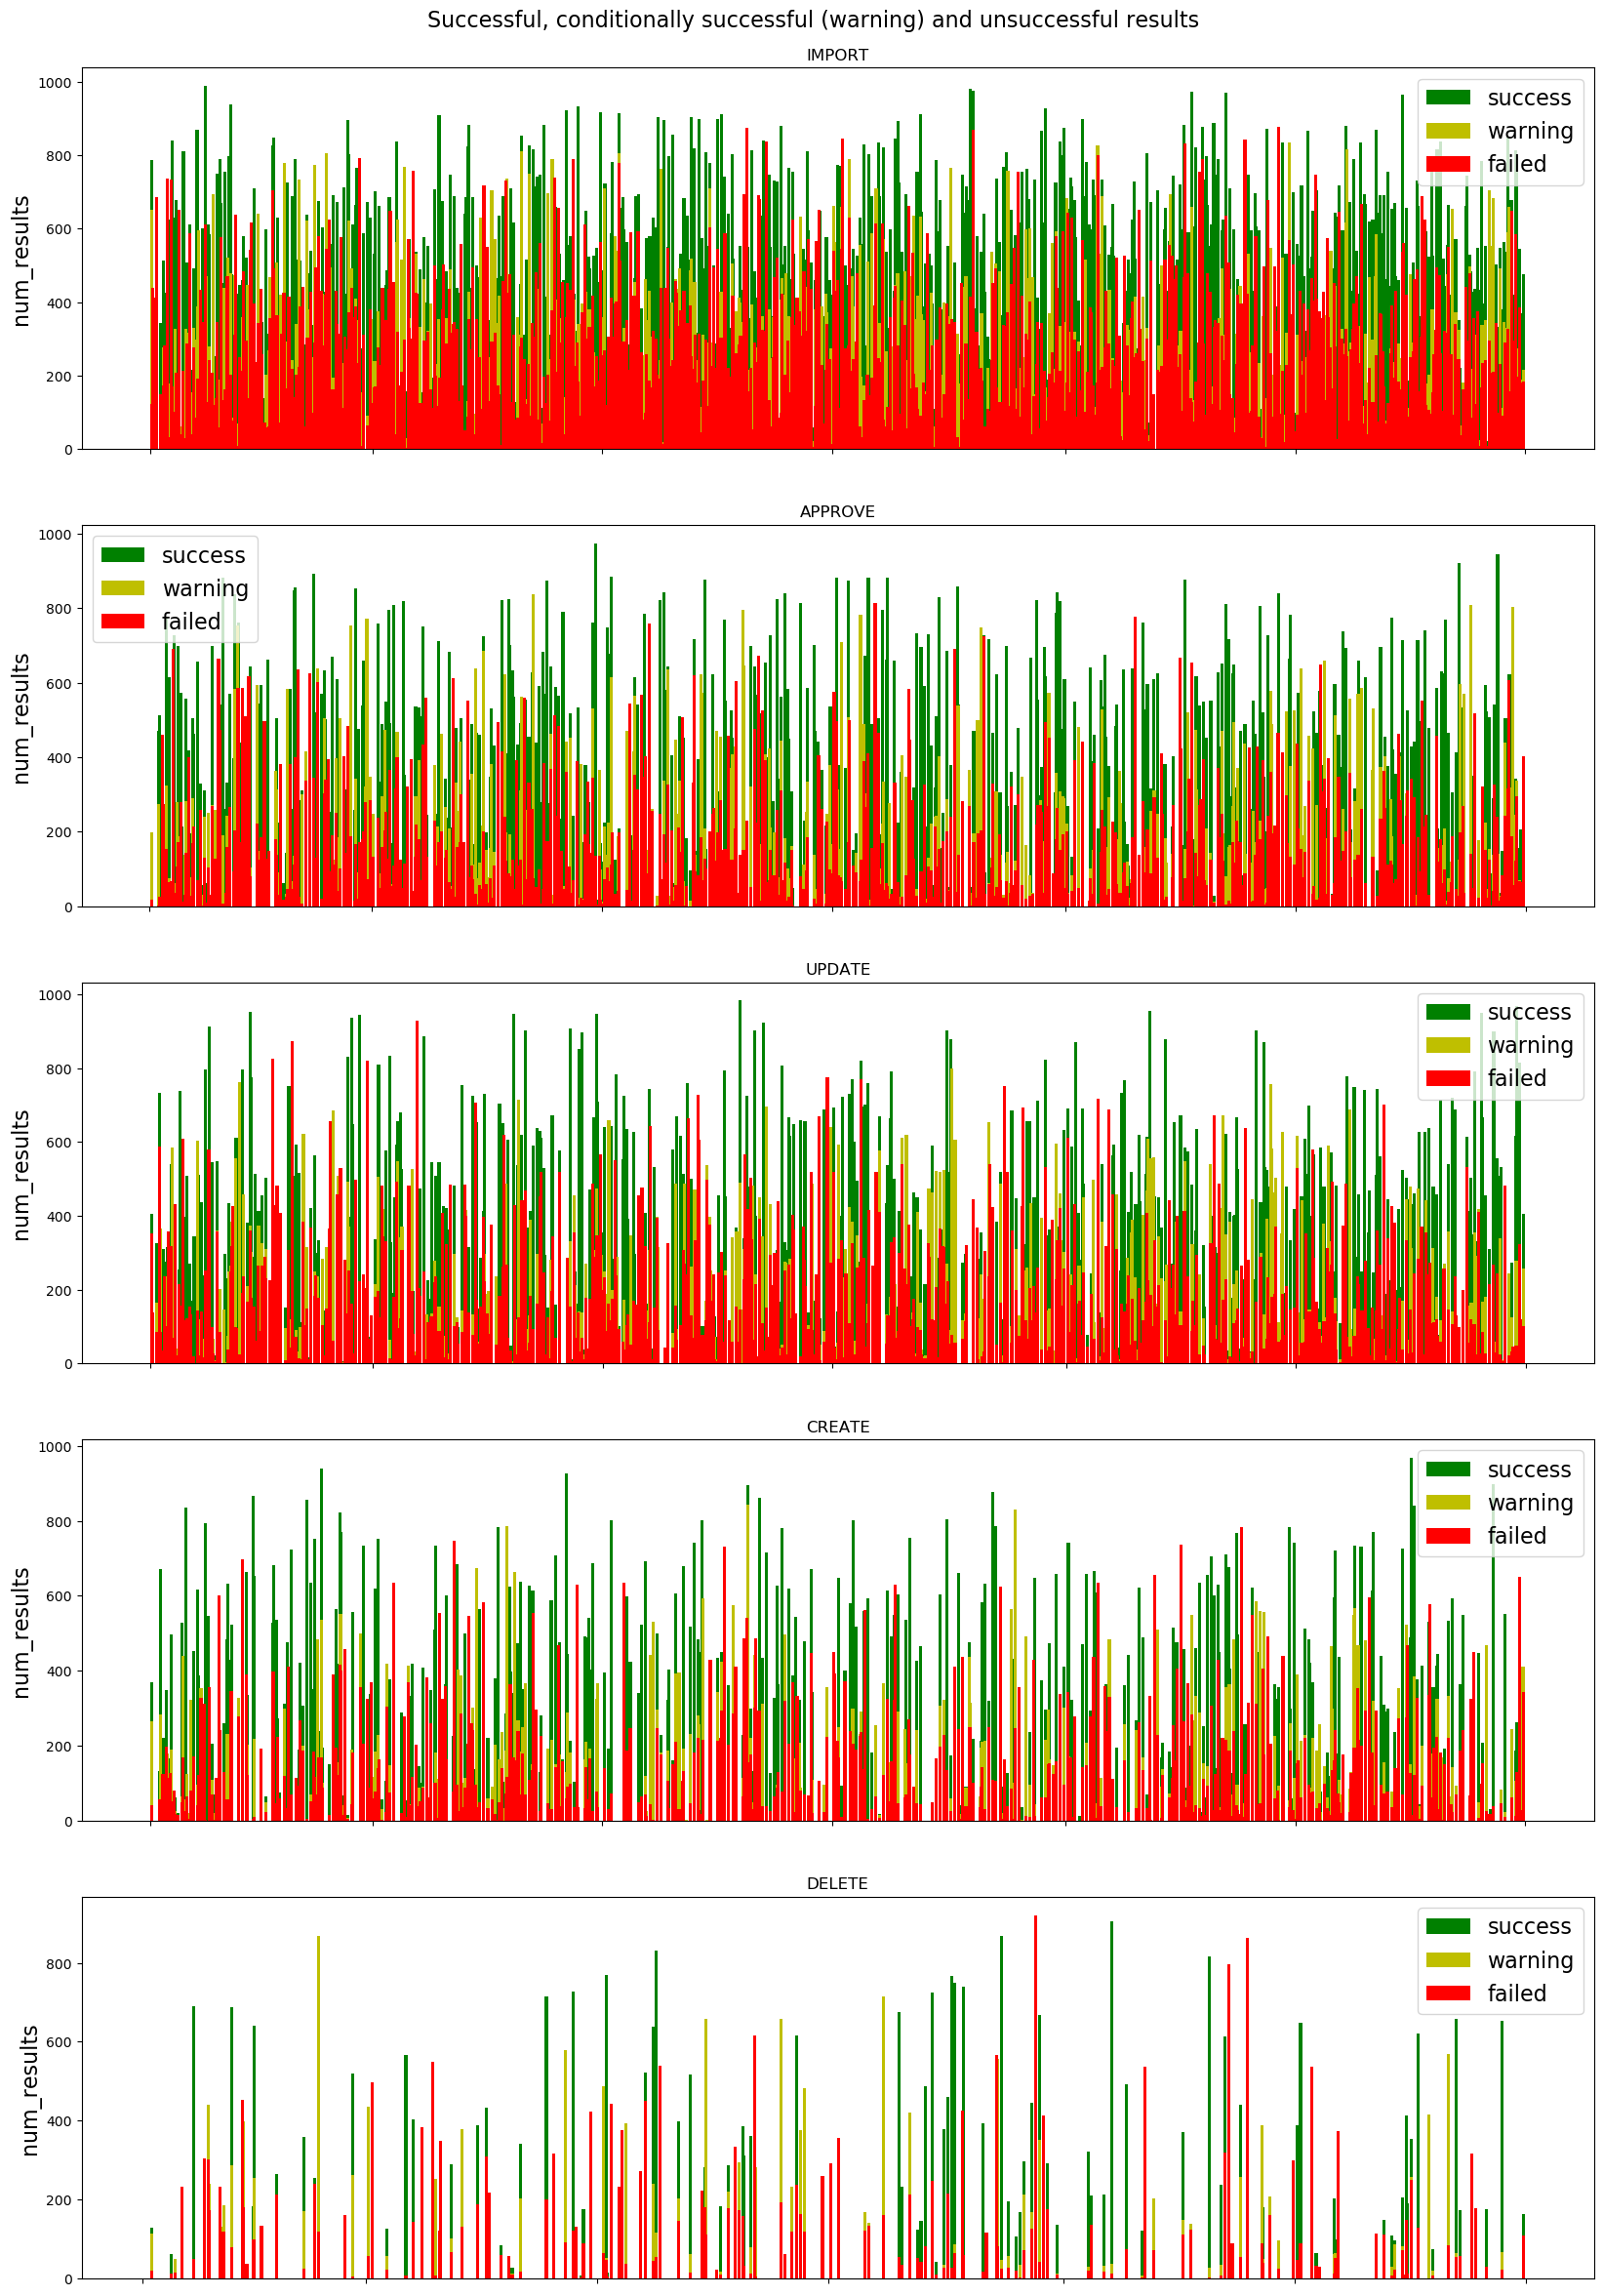

In [14]:
_, axes = plt.subplots(5, 1, figsize=(20,30), dpi=100)
rc('ytick', labelsize=16)

for i, (ax, action) in enumerate(zip(axes.flatten(), not_srch_act.action.unique())):
    datetime = not_srch_act.loc[not_srch_act.action==action, 'started_at']
    success = not_srch_act.loc[not_srch_act.action==action, 'num_success']
    warning = not_srch_act.loc[not_srch_act.action==action, 'num_warning']
    failed = not_srch_act.loc[not_srch_act.action==action, 'num_failed']
    ax.bar(x=datetime, height=success, color='g')
    ax.bar(x=datetime, height=warning, color='y')
    ax.bar(x=datetime, height=failed, color='r')
    ax.legend(('success', 'warning', 'failed'), prop={'size': 16})
    ax.set_ylabel('num_results', fontsize=16)
    ax.set_xticklabels([])
    ax.set_title(action) 

plt.suptitle('Successful, conditionally successful (warning) and unsuccessful results', y=0.9, size=16)
plt.show()


## Dependence of the time spent on the amount of input data

Text(0.5, 0.93, 'Number of input data for each operation')

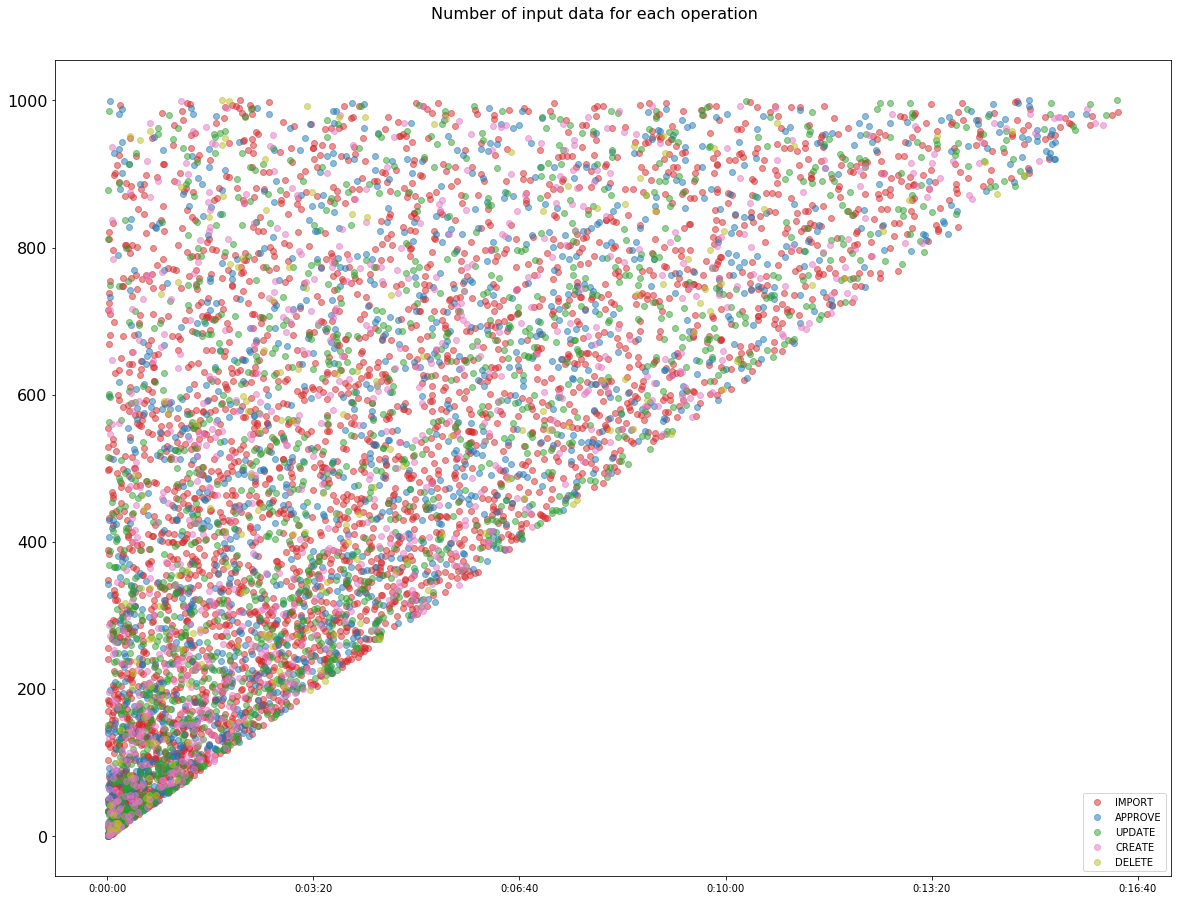

In [15]:
_, ax = plt.subplots(figsize=(20,15))
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:pink', 'tab:olive']

def timeTicks(x, pos):                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
    return str(timedelta(seconds=x))                                                                                                                                                                                                                                                              


for i, action in enumerate(not_srch_act.action.unique()):
    x = not_srch_act.loc[not_srch_act.action==action, 'duration'].astype('timedelta64[s]')
    y = not_srch_act.loc[not_srch_act.action==action, 'num_records']
    ax.scatter(x, y, alpha=0.5, label=str(action), color=colors[i])
    formatter = FuncFormatter(timeTicks)                                                                                                                                                                                                                         
    ax.xaxis.set_major_formatter(formatter)   
    
ax.legend()
plt.suptitle('Number of input data for each operation', y=0.93, size=16)
